## Dependancies

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from pprint import pprint as pp

## Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# Create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# Reflect an existing database into a new model
Base = automap_base()

In [6]:
# Reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II
- Use the `calc_temps` function to calculate the minimum, average, and maximum temperatures for your trip using the matching dates from a previous year (for example, use "2017-08-01").

In [10]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [11]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set

start_trip = '2017-08-01'
end_trip = '2017-08-07'
trip_dates = (calc_temps(start_trip, end_trip))
print("Tmin, Tavg and Tmax From August 2017")
print(trip_dates)

Tmin, Tavg and Tmax From August 2017
[(72.0, 79.25, 83.0)]


In [12]:
columns = [('min','avg','max')]
df = pd.DataFrame(trip_dates,columns = ['min','avg','max'])

print("Trip Date Weather Results From August 2017")
df

Trip Date Weather Results From August 2017


,min,avg,max
0,72.0,79.25,83.0


- Plot the minimum, average, and maximum temperature from your previous query as a bar chart
    - Use "Trip Avg Temp" as the title.
    - Use the average temperature as the bar height (y value).
    - Use the peak-to-peak (TMAX-TMIN) value as the y error bar (YERR).

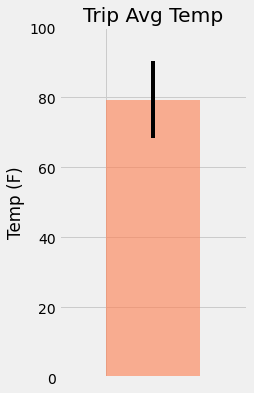

In [13]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

error = [df['max']- df['min']]
df.plot(kind='bar', y='avg', yerr=error, color='coral', alpha=0.6,legend = '',
        figsize=(3,6), title='Trip Avg Temp',align='edge')
plt.ylim(0,100)
plt.ylabel("Temp (F)")
plt.tick_params(axis='x', which='both', labelbottom=False)

plt.savefig("../Images/trip_avg_temp.png")
plt.show()

## Daily Rainfall Average

#### Let’s find out what the rainfall has been by completing the following steps:
- Calculate the rainfall per weather station using the previous year's matching dates.
    - Sort this in descending order by precipitation amount, and list the station, name, latitude, longitude, and elevation.

In [14]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = [Station.station, Station.name,Station.latitude,Station.longitude, Station.elevation,func.sum(Measurement.tobs)]
rainfall_weather = session.query(*sel).group_by(Measurement.station).\
                    outerjoin(Station, Measurement.station==Station.station).\
                    filter(Measurement.date >= '2015-02-01').\
                    filter(Measurement.date <= '2015-02-14').\
                    order_by(func.sum(Measurement.tobs).desc()).all()
pp(rainfall_weather)

[('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 982.0),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 974.0),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 947.0),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 908.0),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 753.0),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 740.0),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 713.0),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 713.0)]


## Daily Temperature Normals
#### Calculate the daily normals for the duration of your trip by completing the following steps:
- Set the start and end date of the trip.
- Use the date to create a range of dates.
- Strip off the year, and save a list of strings in the format `%m-%d`.
- Use the `daily_normals` function to calculate the normals for each date string, and append the results to a list called `normals`.
- Load the list of daily normals into a Pandas DataFrame, and set the index equal to the date.
- Use Pandas to plot an area plot (`stacked=False`) for the daily normals

In [15]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [16]:
# Calculate daily normals for your trip
# Put each calculation into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
range_date = pd.date_range(start_trip , end_trip).strftime('%Y-%m-%d')

# Strip off the year and save a list of strings in the format %m-%d
range_date_strip = pd.date_range(start_trip , end_trip).strftime('%m-%d')

# Use the `daily_normals` function to calculate the normals for each date string 
# Then append the results to a list called `normals`.
normal_list = []

for date in range_date_strip:
    normal = daily_normals(date)
    normal_list.append(normal)
    
pp(normal_list)

[[(67.0, 75.54, 83.0)],
 [(68.0, 75.60377358490567, 84.0)],
 [(70.0, 76.61111111111111, 85.0)],
 [(69.0, 76.71153846153847, 84.0)],
 [(69.0, 76.14814814814815, 82.0)],
 [(67.0, 76.25, 83.0)],
 [(71.0, 77.15686274509804, 83.0)]]


In [17]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

trip_df = pd.DataFrame([n[0] for n in normal_list], columns=["temp_min", "temp_avg", "temp_max"], index=range_date)
trip_df.index.name='Date'
trip_df

,temp_min,temp_avg,temp_max
Date,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


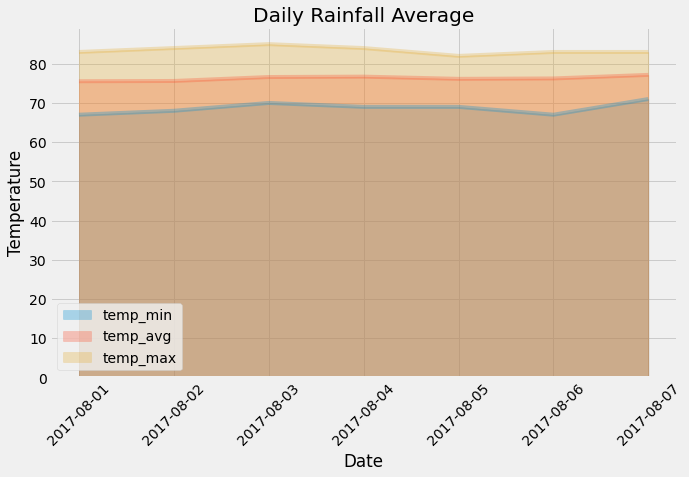

In [18]:
# Plot the daily normals as an area plot with `stacked=False`

trip_df.plot(kind="area", stacked=False, alpha=.3,figsize=(10,6))
plt.title("Daily Rainfall Average")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend(loc='best')
plt.xticks(rotation=45)

plt.savefig("../Images/daily_rainfall_avg.png")
plt.show()

## Close Session

In [19]:
session.close()